# Control in a continuous action space with DDPG
_Authors:_ Aristotelis Dimitriou, Konstantinos Spinakis

---

### Introduction

In this reinforcement learning project, we implement the Deep Deterministic Policy Gradient (DDPG) algorithm to handle continuous action spaces while maintaining the benefits of Deep Q-learning (DQN). The objective is to stabilize an inverted pendulum in the Pendulum-v1 environment from OpenAI Gym.

DDPG is an actor-critic algorithm that utilizes one neural network (critic) to estimate the Q function and another (actor) to select the action. It is based on the deterministic policy gradient theorem, allowing both the actor and critic to be trained off-policy from a replay buffer. The policy network outputs a specific action instead of a probability distribution, enabling a flexible exploration strategy.

* The `Pendulum-v1` environment provides a three-dimensional observation vector $(\cos(\alpha), \sin(\alpha), \dot{\alpha})$ where $\alpha$ represents the angle between the pendulum and the vertical line. 

* The action is a scalar value between -2 and 2, representing the torque applied to the pendulum's unique joint. 

* The control policy must learn to swing the pendulum to gain momentum before stabilizing it in a vertical position with minimal torque. 

* The reward function is defined as $-(\alpha^2 + 0.1\cdot\dot{\alpha}^2 + 0.001\cdot\tau^2)$, with the maximum reward of 0 achieved when the pendulum is vertically positioned, motionless, and with no torque applied.


In [13]:
import gym
import numpy as np
from helpers import NormalizedEnv, RandomAgent
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
from copy import deepcopy


collect_data_q4 = True
collect_data_q5 = True # Don't change this back to True, the results are good
collect_data_q6 = False # Don't change this back to True, the results are good, maybe
collect_data_q7 = False


___
### Heuristic Policy

In this section, we will familiarize ourselves with the `Pendulum-v1` environment by implementing a simple heuristic policy to attempt stabilizing the pendulum. We will compare the heuristic policy with a random policy to verify the increase in average reward.

_**Tasks:**_


1. Create an instance of the `Pendulum-v1` environment and wrap it in a `NormalizedEnv` class.

In [14]:
env = NormalizedEnv(gym.make('Pendulum-v1'))

2. Implement a functions that simulates an interaction between the environment and the agent. Returning the average cumulative reward.

In [15]:
def run_agent(agent, env, episodes=10, store_positions=False, verbose=False):
    rewards = []
    positions = []

    for i in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_positions = []
        done = False
        step = 1
                

        while not done:
            if verbose:
                print(f'* Episode {i+1}/{episodes}')
                print(f'Step {step}')
                
            action = agent.compute_action(state)
            next_state, reward, _, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            x, y, a_dot = state
            step += 1
            if store_positions:
                episode_positions.append((x, y))

            if verbose:
                print(f'\tS: ({x:.2f}, {y:.2f}, {a_dot:.2f})', end='\t')
                print(f'\tA: {action[0]:.2f}', end='\t')
                print(f'\tR: {reward:.2f}', end='\t')
                print(f'\tD: {done}')
                print('----------------------')
        rewards.append(total_reward)
        if store_positions:
            positions.append(episode_positions)
    return np.mean(rewards), rewards, positions if store_positions else None


3. Implement a heuristic policy for the pendulum (`HeuristicPendulumAgent`).

In [16]:
class HeuristicPendulumAgent:
    def __init__(self, env, fixed_torque=0.5, verbose=False):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.fixed_torque = fixed_torque
        self.verbose = verbose

    def compute_action(self, state):
        y, x, angular_velocity = state

        if self.verbose:
            if y < 0:
                print('Lower half of the domain')
            else:
                print('Upper half of the domain')

        if y < 0:   # Lower half of the domain
            action = np.sign(angular_velocity) * self.fixed_torque
        else:       # Upper half of the domain
            action = -np.sign(angular_velocity) * self.fixed_torque
        return np.array([action])


5. Compare the average cumulative reward obtained by the heuristic policy and compare it with the reward of the random agent.

Random agent average reward: -1319.03
Heuristic agent average reward: -496.36


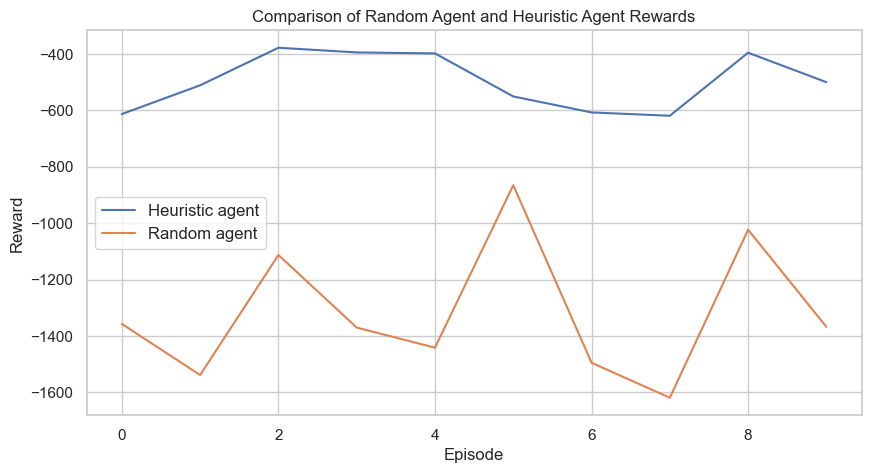

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

verbose = False

heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=1, verbose=verbose)
random_agent = RandomAgent(env, verbose=verbose)

ha_avg_reward, ha_rewards, _  = run_agent(heuristic_agent, env, episodes=10, verbose=verbose)
ra_avg_reward, ra_rewards, _ = run_agent(random_agent, env, episodes=10, verbose=verbose)
print(f'Random agent average reward: {ra_avg_reward:.2f}')
print(f'Heuristic agent average reward: {ha_avg_reward:.2f}')


# Set the style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data using seaborn
sns.lineplot(data=ha_rewards, label='Heuristic agent', ax=ax)
sns.lineplot(data=ra_rewards, label='Random agent', ax=ax)

# Set the labels and title
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Reward', fontsize=12)
ax.set_title('Comparison of Random Agent and Heuristic Agent Rewards')

# Set the legend
ax.legend(loc='best', fontsize=12)

# Show the plot
plt.show()


In [18]:
print("Random Agent", ra_rewards)
print("Heuristic Agent", ha_rewards)

Random Agent [-1357.3100809471246, -1538.4394827786286, -1112.7360745366582, -1370.1031582411858, -1441.5466638834619, -865.2764986646588, -1494.8785248826212, -1619.1615122052908, -1023.2054161147868, -1367.6902659545967]
Heuristic Agent [-612.7063877990728, -510.7318289194379, -377.53949380981334, -394.16917723607503, -397.5868454962919, -550.2755280815475, -606.9682861128484, -618.8124207394342, -395.13008459162876, -499.6619156980793]


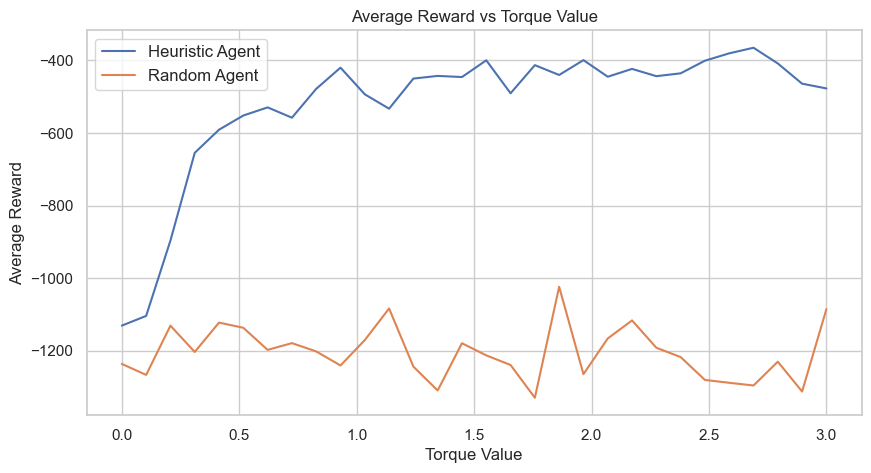

In [19]:
import matplotlib.pyplot as plt

def plot_rewards(torque_values, ha_rewards_list, ra_rewards_list):
    # Set the style
    sns.set(style="whitegrid")

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 5))

    # Calculate the mean rewards
    ha_means = [np.mean(rewards) for rewards in ha_rewards_list]
    ra_means = [np.mean(rewards) for rewards in ra_rewards_list]

    # Plot the data using seaborn
    sns.lineplot(x=torque_values, y=ha_means, label='Heuristic Agent', ax=ax)
    sns.lineplot(x=torque_values, y=ra_means, label='Random Agent', ax=ax)

    # Set the labels and title
    ax.set_xlabel('Torque Value', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title('Average Reward vs Torque Value')

    # Set the legend
    ax.legend(loc='best', fontsize=12)

    # Show the plot
    plt.grid(True)
    plt.show()

    

torque_values = np.linspace(0, 3, 30)
ha_rewards_list = []
ra_rewards_list = []

for torque in torque_values:
    heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=torque)
    ha_avg_reward, ha_rewards, _ = run_agent(heuristic_agent, env)
    ra_avg_reward, ra_rewards, _ = run_agent(random_agent, env)
    
    ha_rewards_list.append(ha_rewards)
    ra_rewards_list.append(ra_rewards)

plot_rewards(torque_values, ha_rewards_list, ra_rewards_list)


In [20]:
class ReplayBuffer:
    """ A buffer for storing transitions sampled from the environment. """
    def __init__(self, max_size, verbose=False):
        self.max_size = max_size
        self.transitions = []
        self.verbose = verbose
        
    def store(self, transition):
        """ Store a transition. """
        if self.verbose:
            print(f'Storing transition {transition}')
            
        if len(self.transitions) < self.max_size:
            self.transitions.append(transition)
        else:
            self.transitions.pop(0)
            self.transitions.append(transition)
        
    def sample(self, batch_size):
        """ Sample a batch of transitions. """
        batch = []
        for _ in range(batch_size):
            idx = np.random.randint(0, len(self.transitions))
            batch.append(self.transitions[idx])
            if self.verbose:
                print(f'Sampling transition {self.transitions[idx]}')
        return batch
    
    def __len__(self):
        return len(self.transitions)
    
        

In [21]:
class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        """ Forward pass of the network. """
        x = x.view(-1, 4)   # -1 means infer this dimension
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
        

In [22]:
def train_q_network(q_network, agent, transitions, optimizer, gamma, verbose=False):
    """
    Train Q-Network using 1-step TD-learning rule.

    Parameters:
    q_network (QNetwork): The Q-Network instance to be trained.
    agent (PendulumAgent): The agent used to interact with the environment.
    transitions (list): A list of tuples containing the transitions used for training.
                        Each tuple should have the format (state, action, reward, next_state, trunc).
    optimizer (torch.optim.Optimizer): The optimizer used for updating the Q-Network's weights.
    gamma (float): The discount factor for future rewards (0 <= gamma <= 1).

    Returns:
    loss (float): The loss value after training the Q-Network with the given batch of transitions.
    """

    # Unpack transitions
    states, actions, rewards, next_states, trunc = zip(*transitions)
    next_actions = [agent.compute_action(next_state) for next_state in next_states]
    
    # Convert lists to PyTorch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    next_actions = torch.tensor(next_actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(1)

    # Concatenate states and actions to form input to Q-network
    state_action_pairs = torch.cat([states, actions], dim=1)
    next_state_action_pairs = torch.cat([next_states, next_actions], dim=1)

    # Computes Q-values for the given state-action pairs
    q_values = q_network(state_action_pairs)

    # Compute target Q-values
    with torch.no_grad():
        q_targets = rewards + gamma * q_network(next_state_action_pairs) * (1 - trunc)

    # Compute loss
    #   Use MSE
    loss = torch.nn.functional.mse_loss(q_values, q_targets)

    # Perform backpropagation
    optimizer.zero_grad()   # Reset gradients to zero
    loss.backward()         # Compute gradients
    optimizer.step()        # Update weights

    if verbose:
        print(f'States:\n{states}')
        print(f'Actions:\n{actions}')
        print(f'Rewards:\n{rewards}')
        print(f'Next states:\n{next_states}')
        print(f'Trunc:\n{trunc}')
        print(f'State-action pair:\n{state_action_pairs}')
        print(f'Next state-action pair:\n{next_state_action_pairs}')
        print(f'Q-values:\n{q_values}')
        print(f'Target Q-values:\n{q_targets}')
        print(f'Loss: {loss.item()}')

    return loss.item()



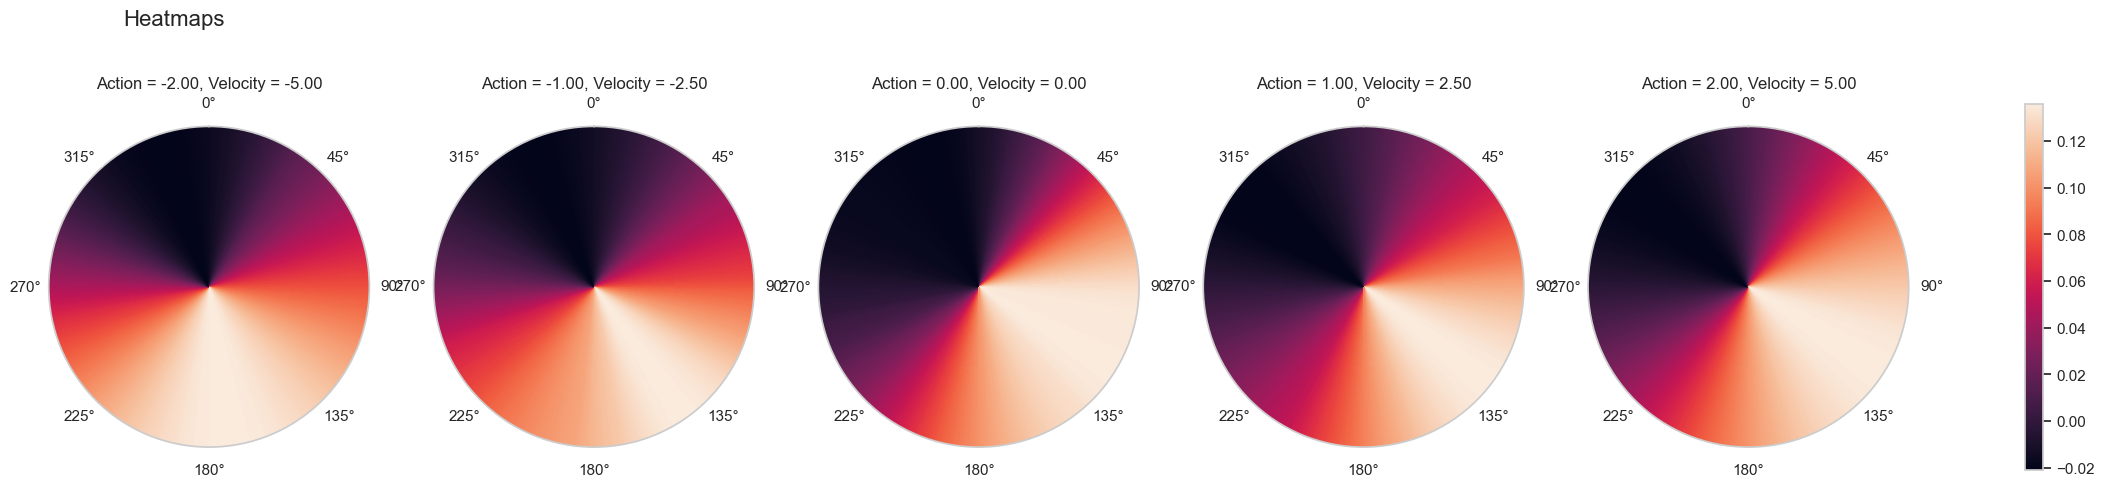

In [23]:
def generate_heatmap_data(q_network, action_values, velocity_values, num_theta=100):
    """
    Generate heatmap data by computing Q-values for given action and velocity pairs at different angular positions.

    Parameters:
    q_network (QNetwork): The trained Q-Network.
    action_values (np.array): Action values for the heatmap.
    velocity_values (np.array): Velocity values for the heatmap.
    num_theta (int): Number of angular positions to evaluate.

    Returns:
    heatmap_data (list): List of 2D arrays with heatmap data.
    """
    
    theta = np.linspace(-np.pi, np.pi, num_theta)

    heatmap_data = {}


    for action, velocity in zip(action_values, velocity_values):
        q_values = []
        for angle in theta:
            state_action = np.array([np.cos(angle), np.sin(angle), velocity, action])
            q_values.append(q_network(torch.tensor(state_action, dtype=torch.float32)).item())
        heatmap_data[(action, velocity)] = q_values

    return heatmap_data

def plot_heatmap(heatmap_data, action_values, velocity_values, num_theta=100, title='Heatmaps'):
    """
    Plot heatmap data.

    Parameters:
    heatmap_data (list): List of 2D arrays with heatmap data.
    action_values (np.array): Action values for the heatmap.
    velocity_values (np.array): Velocity values for the heatmap.
    num_theta (int): Number of angular positions to evaluate.
    """
    # Create a meshgrid for the heatmap
    theta, r = np.meshgrid(
        np.linspace(-np.pi, np.pi, num_theta), np.linspace(0, 1, 2))

    fig, axs = plt.subplots(nrows=1, ncols=5, subplot_kw={'projection': 'polar'}, figsize=(30, 5))
    # Make title be left aligned
    fig.suptitle(title, x=0.15, y=1.05, ha='left', fontsize=16)

    for i, (action, velocity) in enumerate(zip(action_values, velocity_values)):
        q_values = np.array(heatmap_data[(action, velocity)]).reshape(1, -1)
        q_values = np.repeat(q_values, 2, axis=0)  # Repeat the values radially

        ax = axs[i]
        ax.set_theta_zero_location("N")  # Set zero to top
        ax.set_theta_direction(-1)  # Clockwise direction
        ax.set_title(f'Action = {action:.2f}, Velocity = {velocity:.2f}')
        c = ax.pcolormesh(theta, r, q_values, shading='auto')

        # Remove radial labels and ticks
        ax.set_yticklabels([])
        ax.set_yticks([])

    fig.colorbar(c, ax=axs.ravel().tolist(), shrink=0.95)
    # plt.tight_layout()
    plt.show()


num_theta = 1000
q_network = QNetwork()
action_values = np.linspace(-2, 2, 5)
velocity_values = np.linspace(-5, 5, 5)
heatmap_data = generate_heatmap_data(q_network, action_values, velocity_values, num_theta=num_theta)
plot_heatmap(heatmap_data, action_values, velocity_values, num_theta=num_theta)

Episode 1000/1000


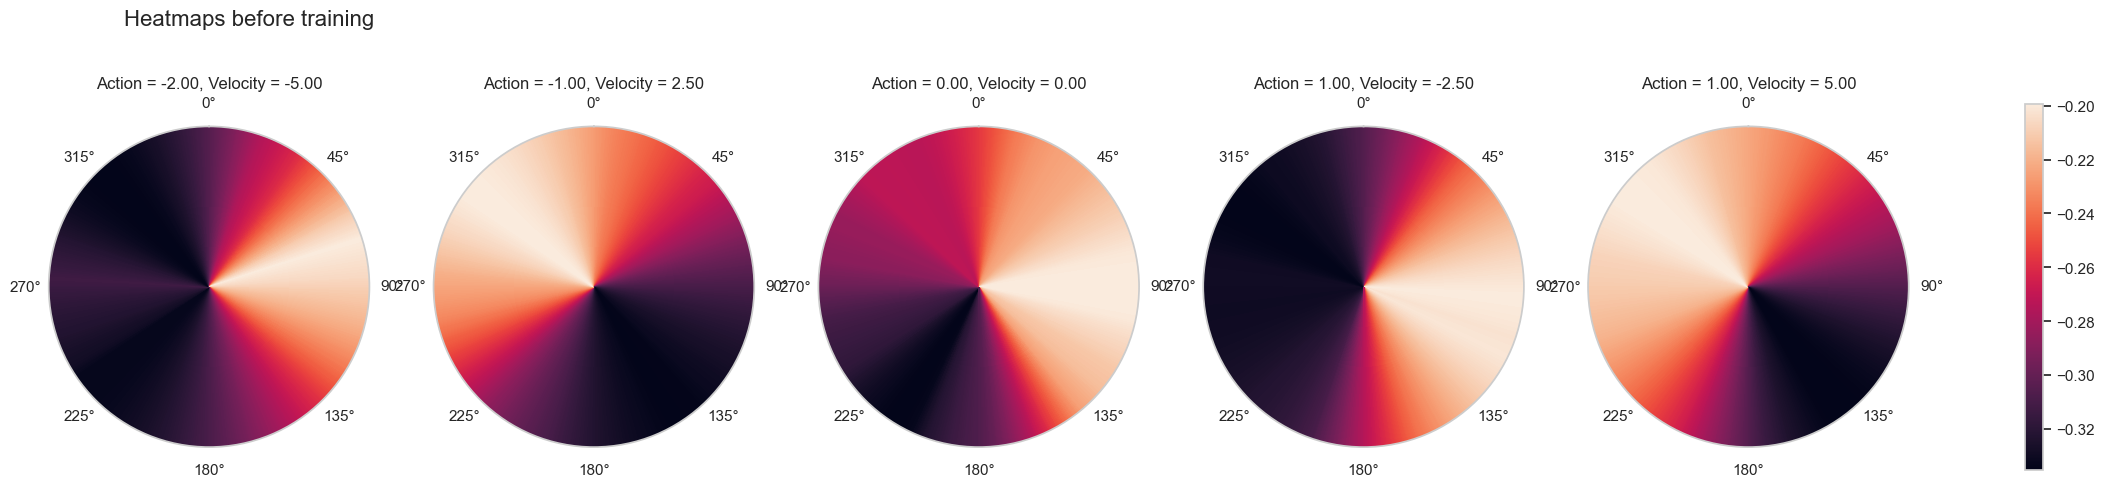

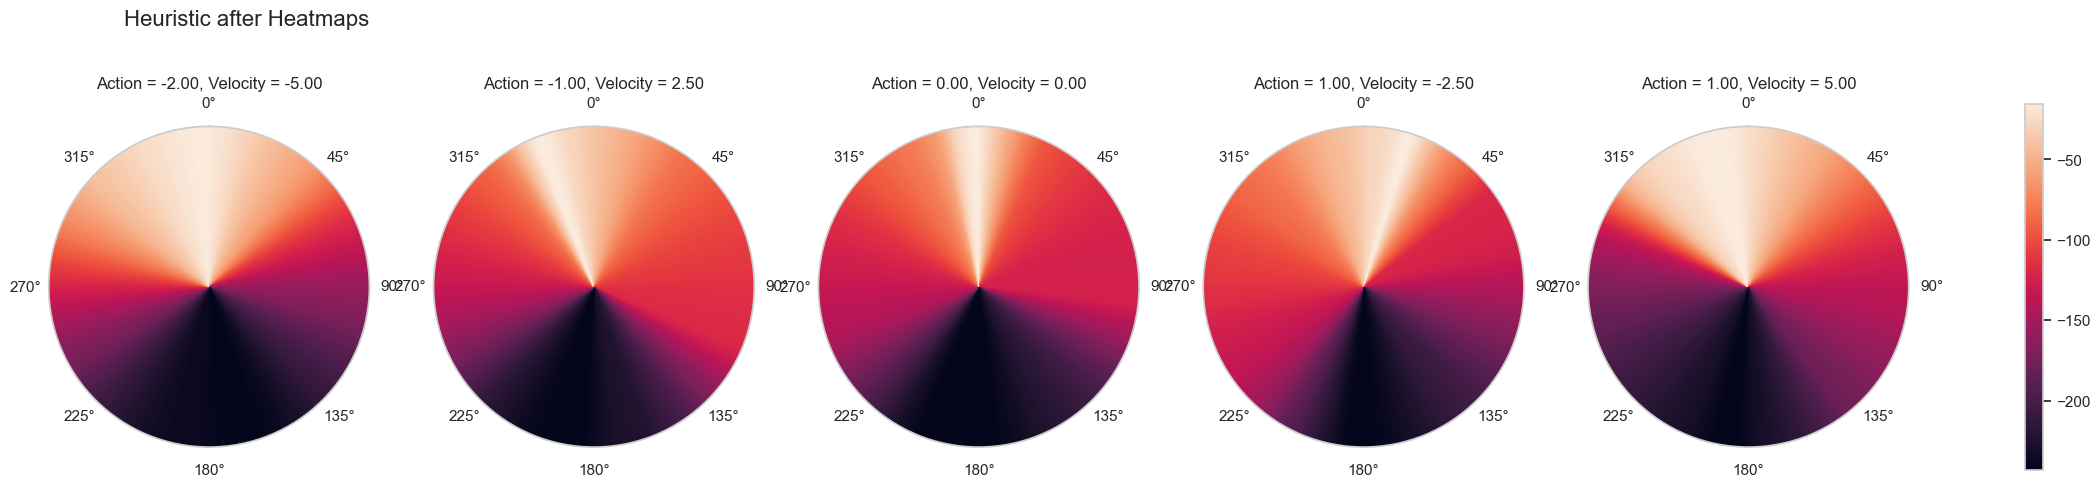

In [24]:
if collect_data_q4:
    replay_buffer = ReplayBuffer(max_size=1e4, verbose=False)
    q_network = QNetwork()
    optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)
    heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=1)

    # Define the angular positions, action, and velocity pairs
    n_pairs = 5
    num_theta = 1000
    action_values = np.array([-2, -1, 0, 1, 1])
    velocity_values = np.array([-5, 2.5, 0, -2.5, 5])

    heatmap_data_before = generate_heatmap_data(q_network, action_values, velocity_values, num_theta=num_theta)
    df_before = pd.DataFrame(heatmap_data_before, columns=['q_values'], index=range(1, n_pairs + 1))
    df_before.index.name = 'Action/Velocity pairs'
    df_before.to_csv('data/q4_before.csv')

    n_episodes = 1000
    max_timesteps = 200
    batch_size = 128
    gamma = 0.99

    episode_losses = []

    for episode in range(n_episodes):
        clear_output(wait=True)
        print(f'Episode {episode + 1}/{n_episodes}')
        state, _ = env.reset()
        episode_loss = 0

        for t in range(max_timesteps):
            action = heuristic_agent.compute_action(state)
            next_state, reward, _, done,  _ = env.step(action)

            transition = (state, action, reward, next_state, done)
            replay_buffer.store(transition)

            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                # print(f'Batch: {batch}')
                loss = train_q_network(q_network, heuristic_agent, batch, optimizer, gamma)
                episode_loss += loss

            state = next_state

            if done:
                break

        episode_losses.append(episode_loss)

    heatmap_data_after = generate_heatmap_data(q_network, action_values, velocity_values, num_theta=num_theta)
    df_after = pd.DataFrame(heatmap_data_after, columns=['q_values'], index=range(1, n_pairs + 1))
    df_after.index.name = 'Action/Velocity pairs'
    df_after.to_csv('data/q4_after.csv')

    df = pd.DataFrame(episode_losses, columns=['loss'], index=range(1, n_episodes + 1))
    df.index.name = 'Episode'
    df.to_csv('data/ddpg_q4.csv')

    plot_heatmap(heatmap_data_before, action_values, velocity_values, num_theta=num_theta, title='Heatmaps before training')
    plot_heatmap(heatmap_data_after, action_values, velocity_values, num_theta=num_theta, title='Heuristic after Heatmaps')



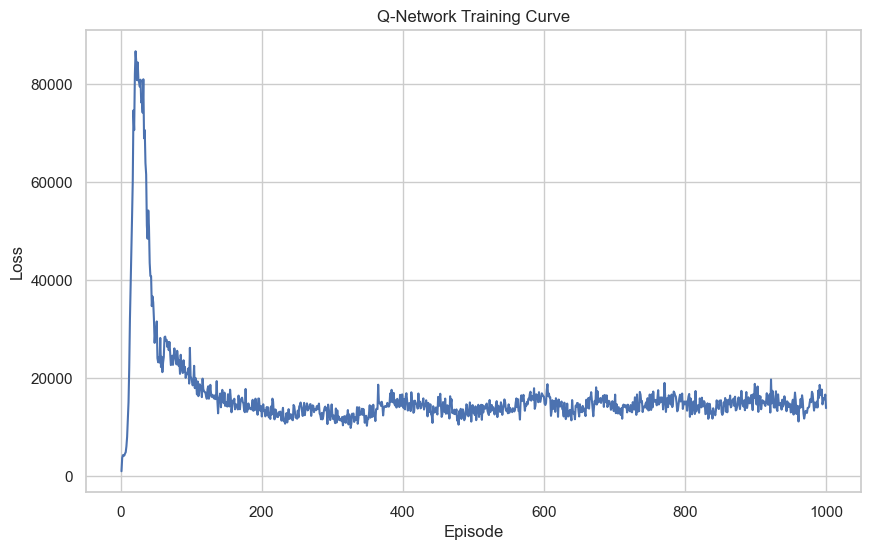

In [25]:
# Read the data from the CSV file
df = pd.read_csv('data/q4/ddpg_q4.csv', index_col='Episode')

# Set the style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data using seaborn
sns.lineplot(data=df['loss'], ax=ax)

# Set the labels and title
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Q-Network Training Curve')

# Show the plot
plt.show()


___

In [26]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """ Forward pass of the network. """
        x = x.view(-1, 3)   # -1 means infer this dimension
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x


In [27]:
class GaussianActionNoise:
    def __init__(self, sigma):
        self.sigma = sigma

    def get_noisy_action(self, action):
        """ Adds Gaussian noise to the given action. """
        noise = np.random.normal(0, self.sigma)
        return np.clip(action + noise, -1, 1)

In [28]:
class DDPGAgent:
    def __init__(self, policy_network, critic_network, action_noise):
        self.action_noise = action_noise
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_network = policy_network.to(self.device)
        self.critic_network = critic_network.to(self.device)
        self.target_policy_network = deepcopy(policy_network).to(self.device)
        self.target_critic_network = deepcopy(critic_network).to(self.device)



    def compute_action(self, state, deterministic=False):
        """ Computes an action from the given state. """
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        action = self.policy_network(state).detach().numpy()
        if deterministic:
            return action
        else:
            return self.action_noise.get_noisy_action(action)
        
    def update_target_params(self, tau):
        for target_param, param in zip(self.target_policy_network.parameters(), self.policy_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(self.target_critic_network.parameters(), self.critic_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [29]:
def train_actor_critic(agent, transitions, actor_optimizer, critic_optimizer, gamma, train_networks=False):

    states, actions, rewards, next_states, trunc = zip(*transitions)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(1)

    # Train the Critic
    if train_networks:
        next_actions = agent.target_policy_network(next_states)
    else:
        next_actions = agent.policy_network(next_states)
    state_action_pairs = torch.cat([states, actions], dim=1)
    next_state_action_pairs = torch.cat([next_states, next_actions], dim=1)

    # Computes Q-values for the given state-action pairs
    q_values = agent.critic_network(state_action_pairs)

    # Compute target Q-values
    with torch.no_grad():
        if train_networks:
            next_q_values = agent.target_critic_network(next_state_action_pairs)
        else:
            next_q_values = agent.critic_network(next_state_action_pairs)
            
        q_targets = rewards + gamma * next_q_values * (1 - trunc).detach()

    # Compute loss
    #   Use MSE
    critic_loss = torch.nn.functional.mse_loss(q_values, q_targets)

    # Perform backpropagation
    critic_optimizer.zero_grad()
    critic_loss.backward()         # Compute gradients
    critic_optimizer.step() 
    
    # Train the Actor
    actions = agent.policy_network(states)
    state_action_pairs = torch.cat([states, actions], dim=1)
    q_values = agent.critic_network(state_action_pairs)
    actor_loss = -q_values.mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()         # Compute gradients
    actor_optimizer.step()
    
    return actor_loss.item(), critic_loss.item() # actor_loss, critic_loss

Episode 1000/1000
Average cumulative reward: -1100.8132426655213


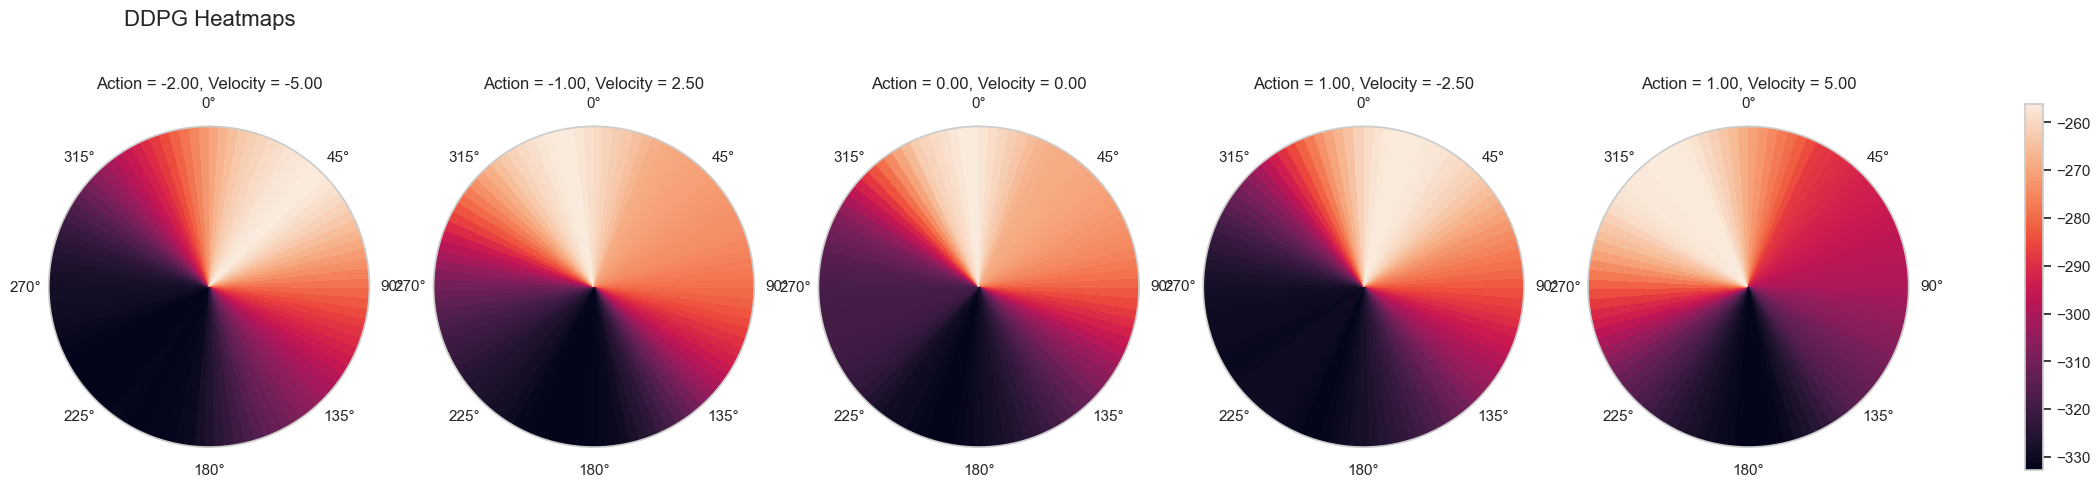

In [33]:

if collect_data_q5:
    # Initialize networks, replay buffer, and noise
    policy_network = PolicyNetwork()
    q_network = QNetwork()
    replay_buffer = ReplayBuffer(max_size=int(1e5), verbose=False)
    action_noise = GaussianActionNoise(sigma=0.3)
    ddpg_agent = DDPGAgent(policy_network, q_network, action_noise)

    actor_optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4)
    critic_optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)

    n_episodes = 1000
    max_timesteps = 200
    batch_size = 128
    gamma = 0.99

    episode_actor_losses = []
    episode_critic_losses = []
    episode_rewards = []

    for episode in range(n_episodes):
        clear_output(wait=True)
        print(f'Episode {episode + 1}/{n_episodes}')
        state, _ = env.reset()
        episode_actor_loss = 0
        episode_critic_loss = 0
        episode_reward = 0

        for t in range(max_timesteps):
            action = ddpg_agent.compute_action(state, deterministic=False).squeeze(0)
            next_state, reward, _, done, _ = env.step(action)
            
            transition = (state, action, reward, next_state, done)
            replay_buffer.store(transition)
            state = next_state
            episode_reward += reward

            if len(replay_buffer) > batch_size:
                batch = replay_buffer.sample(batch_size)
                actor_loss, critic_loss = train_actor_critic(
                    ddpg_agent, batch, actor_optimizer, critic_optimizer, gamma)
                episode_actor_loss += actor_loss
                episode_critic_loss += critic_loss

            if done:
                break

        episode_actor_losses.append(episode_actor_loss / (t+1))
        episode_critic_losses.append(episode_critic_loss / (t+1))
        episode_rewards.append(episode_reward)

    # Testing the trained policy
    test_episodes = 100
    test_rewards = []

    for episode in range(test_episodes):
        state, _ = env.reset()
        episode_reward = 0

        while True:
            action = ddpg_agent.compute_action(state, deterministic=True).squeeze(0)
            next_state, reward, _, done, _ = env.step(action)
            state = next_state
            episode_reward += reward

            if done:
                break

        test_rewards.append(episode_reward)

    print("Average cumulative reward:", np.mean(test_rewards))

    df_train = pd.DataFrame({'Reward': episode_rewards, 'Actor Loss': episode_actor_losses, 'Critic Loss': episode_critic_losses}, index=range(1, n_episodes + 1), columns=['Reward', 'Actor Loss', 'Critic Loss'])
    df_train.index.name = 'Episode'
    df_train.to_csv('data/ddpg_q5_train.csv')

    df_test = pd.DataFrame({'Reward': test_rewards}, index=range(1, test_episodes + 1), columns=['Reward'])
    df_test.index.name = 'Episode'
    df_test.to_csv('data/ddpg_q5_test.csv')

    # Choose the action and velocity values to generate the heatmap for
    action_values = np.array([-2, -1, 0, 1, 1])
    velocity_values = np.array([-5, 2.5, 0, -2.5, 5])

    # Generate the heatmap data
    heatmap_data = generate_heatmap_data(ddpg_agent.critic_network, action_values, velocity_values)

    # Plot the heatmap
    plot_heatmap(heatmap_data, action_values, velocity_values, title='DDPG Heatmaps')




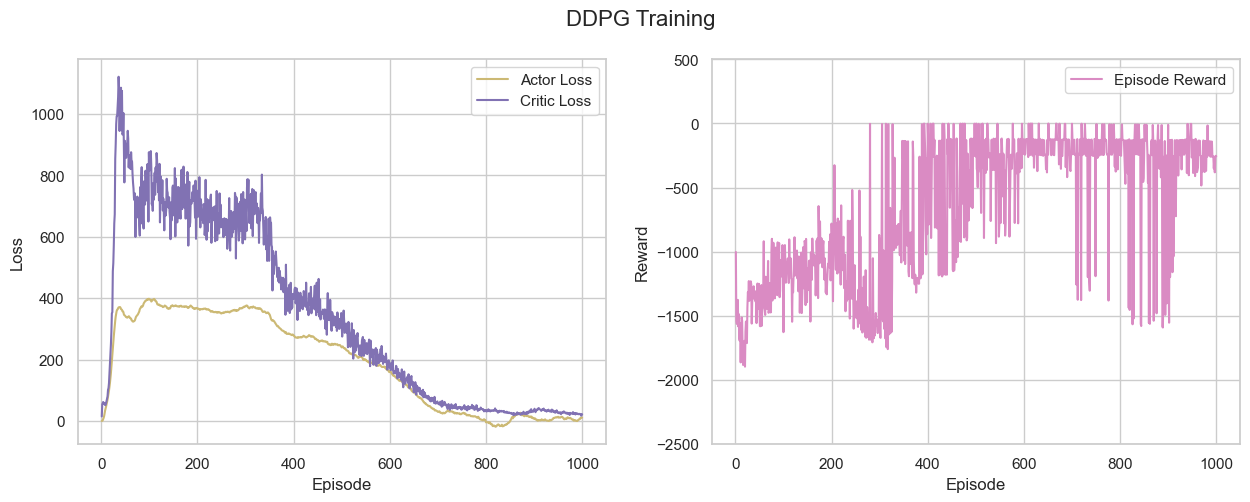

Average cumulative reward: -165.04424969329907


In [31]:
# Load data
df = pd.read_csv('data/q5/ddpg_q5_train.csv', index_col='Episode')

colors = sns.color_palette()

# Set up a grid of plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('DDPG Training', fontsize=16)

# Plotting the learning curves
sns.lineplot(data=df, x=df.index, y='Actor Loss',
             ax=ax[0], label='Actor Loss', color=colors[8])
sns.lineplot(data=df, x=df.index, y='Critic Loss',
             ax=ax[0], label='Critic Loss', color=colors[4])
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Loss')
ax[0].legend()

sns.lineplot(data=df, x=df.index, y='Reward',
             ax=ax[1], label='Episode Reward', color=colors[6])
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Reward')
ax[1].set_ylim([-2500, 500])
ax[1].legend()

plt.show()


# Load data
df = pd.read_csv('data/q5/ddpg_q5_test.csv', index_col='Episode')

# # Plotting the learning curves
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(df['Reward'], label='Episode Reward', color="#4DBEEE")
# ax.set_xlabel('Episode')
# ax.set_ylabel('Reward')
# ax.set_ylim([-1000, 500])
# ax.legend()
# plt.show()

print("Average cumulative reward:", np.mean(df['Reward']))


___

In [32]:

if collect_data_q6:
    n_episodes = 1000
    max_timesteps = 200
    batch_size = 128
    gamma = 0.99
    tau_values = np.logspace(-2, 0, 5)

    for tau in tau_values:
        # Initialize networks, replay buffer, and noise
        policy_network = PolicyNetwork()
        q_network = QNetwork()
        replay_buffer = ReplayBuffer(max_size=int(1e5), verbose=False)
        action_noise = GaussianActionNoise(sigma=0.3)
        ddpg_agent = DDPGAgent(policy_network, q_network, action_noise)

        actor_optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4)
        critic_optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)


        episode_actor_losses = []
        episode_critic_losses = []
        episode_rewards = []

        for episode in range(n_episodes):
            clear_output(wait=True)
            print(f'Tau: {tau}, Episode {episode + 1}/{n_episodes}')
            state, _ = env.reset()
            episode_actor_loss = 0
            episode_critic_loss = 0
            episode_reward = 0

            for t in range(max_timesteps):
                action = ddpg_agent.compute_action(state, deterministic=False).squeeze(0)
                next_state, reward, _, done, _ = env.step(action)
                
                transition = (state, action, reward, next_state, done)
                replay_buffer.store(transition)
                state = next_state
                episode_reward += reward

                if len(replay_buffer) > batch_size:
                    batch = replay_buffer.sample(batch_size)
                    actor_loss, critic_loss = train_actor_critic(ddpg_agent, batch, actor_optimizer, critic_optimizer, gamma, train_networks=True)
                    episode_actor_loss += actor_loss
                    episode_critic_loss += critic_loss

                    ddpg_agent.update_target_params(tau=tau)

                if done:
                    break

            episode_actor_losses.append(episode_actor_loss / (t+1))
            episode_critic_losses.append(episode_critic_loss / (t+1))
            episode_rewards.append(episode_reward)

        # Testing the trained policy
        test_episodes = 100
        test_rewards = []

        for episode in range(test_episodes):
            state, _ = env.reset()
            episode_reward = 0

            while True:
                action = ddpg_agent.compute_action(state, deterministic=True).squeeze(0)
                next_state, reward, _, done, _ = env.step(action)
                state = next_state
                episode_reward += reward

                if done:
                    break

            test_rewards.append(episode_reward)
        
        print("Average cumulative reward:", np.mean(test_rewards))

        df_test = pd.DataFrame({'Reward': episode_rewards, 'Actor Loss': episode_actor_losses, 'Critic Loss': episode_critic_losses}, index=range(1, n_episodes + 1), columns=['Reward', 'Actor Loss', 'Critic Loss'])
        df_test.index.name = 'Episode'
        df_test.to_csv(f'data/ddpg_q6_train_tau_{tau}.csv')

        df_train = pd.DataFrame({'Reward': test_rewards}, index=range(1, test_episodes + 1), columns=['Reward'])
        df_train.index.name = 'Episode'
        df_train.to_csv(f'data/ddpg_q6_test_tau_{tau}.csv')


Tau: 0.01, Episode 183/1000


KeyboardInterrupt: 

Average cumulative reward (tau: 0.01): -463.9368570101384
Average cumulative reward (tau: 0.03): -550.311925274633
Average cumulative reward (tau: 0.10): -634.4753854239563
Average cumulative reward (tau: 0.32): -1107.647217430067
Average cumulative reward (tau: 1.00): -1014.6444833541711


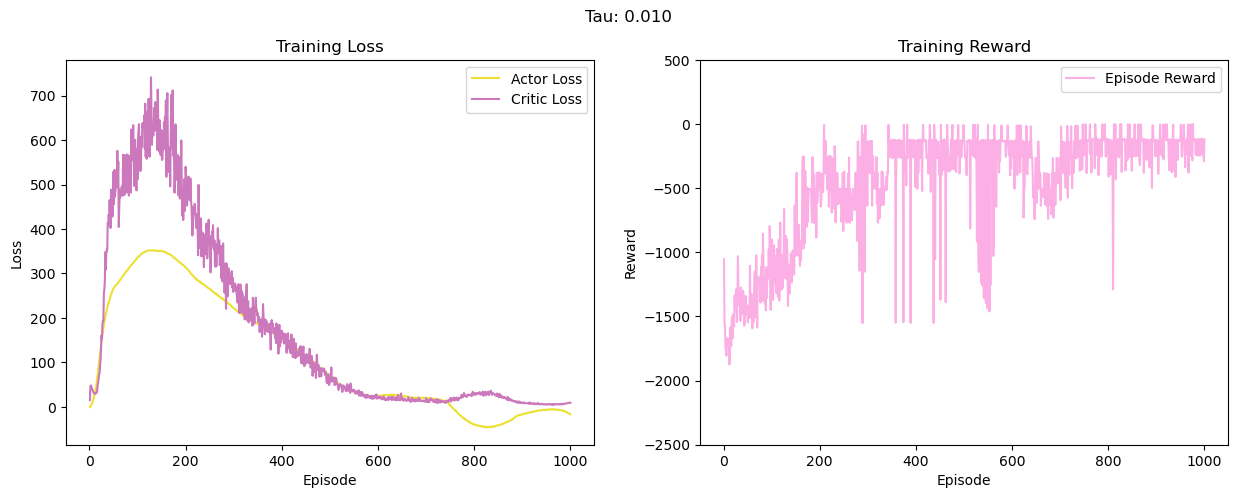

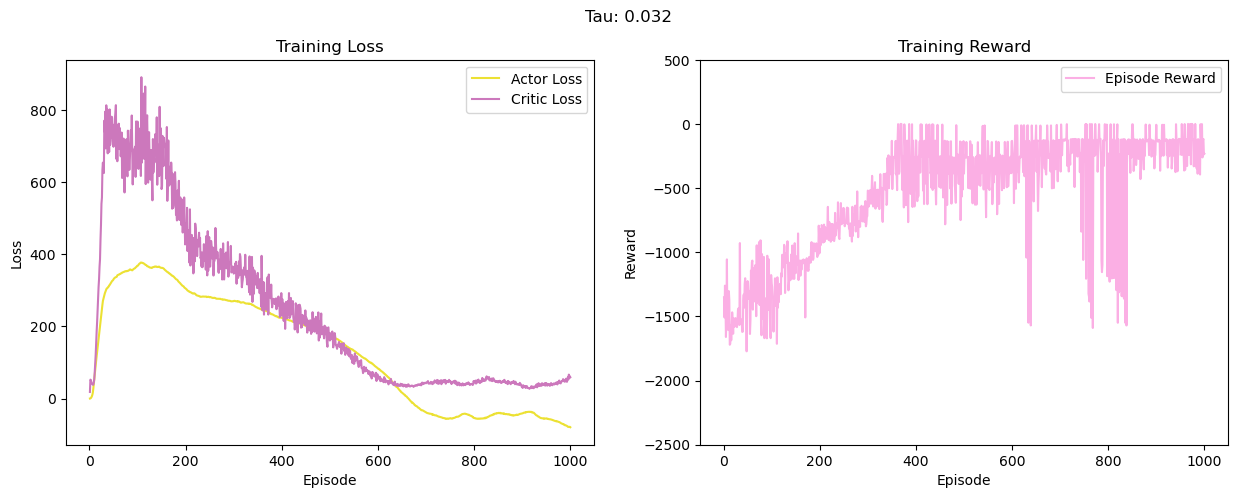

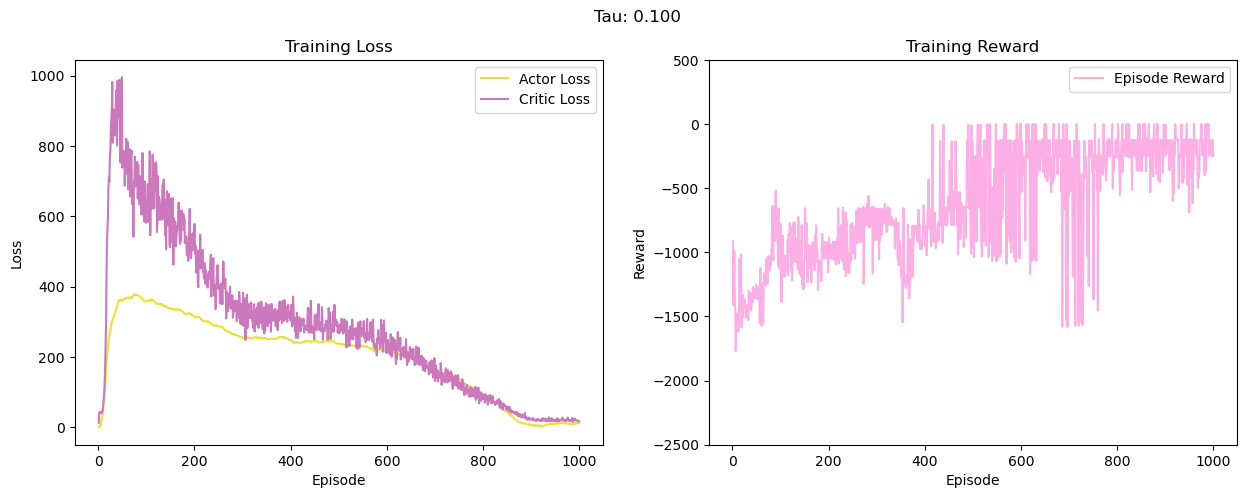

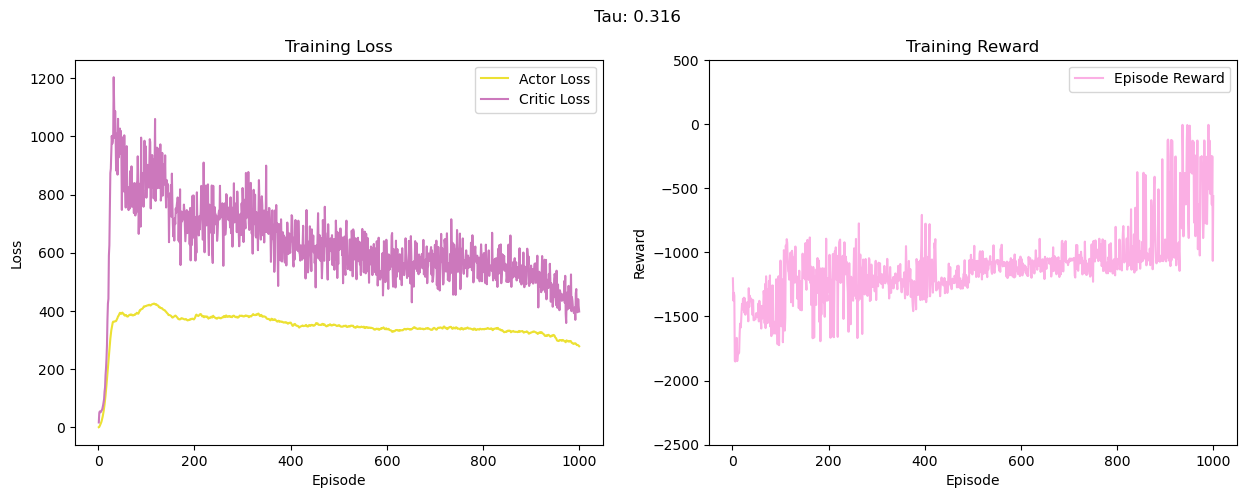

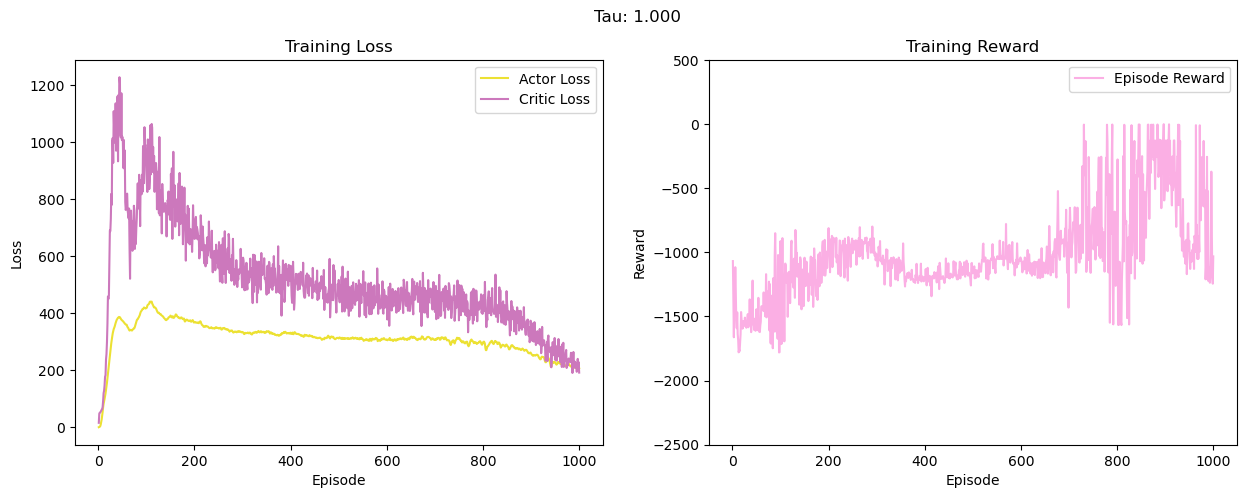

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

tau_values = np.logspace(-2, 0, 5)
colors = sns.color_palette('colorblind')


for tau in tau_values:
    df_train = pd.read_csv(f'data/q6/ddpg_q6_train_tau_{tau}.csv', index_col='Episode')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Tau: {tau:.3f}')

    # Plotting the learning curves
    sns.lineplot(data=df_train, x=df_train.index, y='Actor Loss', ax=ax[0], label='Actor Loss', color=colors[8])
    sns.lineplot(data=df_train, x=df_train.index, y='Critic Loss', ax=ax[0], label='Critic Loss', color=colors[4])
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    sns.lineplot(data=df_train, x=df_train.index, y='Reward', ax=ax[1], label='Episode Reward', color=colors[6])
    ax[1].set_title('Training Reward')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')
    ax[1].set_ylim([-2500, 500])
    ax[1].legend()

    # plt.show()
    print(f"Average cumulative reward (tau: {tau:.2f}): {np.mean(df_train['Reward'])}")


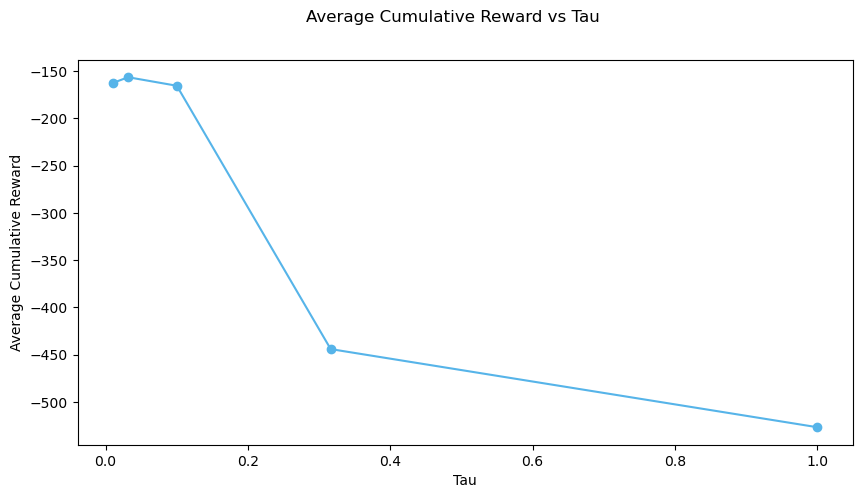

In [ ]:
cumulative_rewards = []

for tau in tau_values:
    df_test = pd.read_csv(
        f'data/q6/ddpg_q6_test_tau_{tau}.csv', index_col='Episode')
    cumulative_rewards.append(np.mean(df_test['Reward'].values))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('Average Cumulative Reward vs Tau')
ax.plot(tau_values, cumulative_rewards, color=colors[9], marker='o')
ax.set_xlabel('Tau')
ax.set_ylabel('Average Cumulative Reward')
# ax.set_xscale('log')
plt.show()


___

In [ ]:
class OUActionNoise:
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
        self.state = 0

    def evolve_state(self):
        self.state = (1 - self.theta) * self.state + \
            np.random.normal(0, self.sigma)

    def get_noisy_action(self, action):
        """ Adds Ornstein-Uhlenbeck noise to the given action. """
        self.evolve_state()
        return np.clip(action + self.state, -1, 1)


In [ ]:
if collect_data_q7:
    chosen_tau = 0.1
    theta_values = [0, 0.2, 0.4, 0.6, 0.8]

    for theta in theta_values:
        policy_network = PolicyNetwork()
        q_network = QNetwork()
        replay_buffer = ReplayBuffer(max_size=int(1e5), verbose=False)
        ou_action_noise = OUActionNoise(theta=theta, sigma=0.3)
        ddpg_agent = DDPGAgent(policy_network, q_network, ou_action_noise)

        actor_optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4)
        critic_optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)

        n_episodes = 1000
        max_timesteps = 200
        batch_size = 128
        gamma = 0.99

        episode_actor_losses = []
        episode_critic_losses = []
        episode_rewards = []

        for episode in range(n_episodes):
            clear_output(wait=True)
            print(f'Theta: {theta}, Episode {episode + 1}/{n_episodes}')
            state, _ = env.reset()
            episode_actor_loss = 0
            episode_critic_loss = 0
            episode_reward = 0

            for t in range(max_timesteps):
                action = ddpg_agent.compute_action(state, deterministic=False).squeeze(0)
                next_state, reward, _, done, _ = env.step(action)
                
                transition = (state, action, reward, next_state, done)
                replay_buffer.store(transition)
                state = next_state
                episode_reward += reward

                if len(replay_buffer) > batch_size:
                    batch = replay_buffer.sample(batch_size)
                    actor_loss, critic_loss = train_actor_critic(ddpg_agent, batch, actor_optimizer, critic_optimizer, gamma)
                    episode_actor_loss += actor_loss
                    episode_critic_loss += critic_loss

                    ddpg_agent.update_target_params(tau=chosen_tau)

                if done:
                    break

            episode_actor_losses.append(episode_actor_loss / (t+1))
            episode_critic_losses.append(episode_critic_loss / (t+1))
            episode_rewards.append(episode_reward)

        df_train = pd.DataFrame({'Reward': episode_rewards, 'Actor Loss': episode_actor_losses, 'Critic Loss': episode_critic_losses}, index=range(1, n_episodes + 1), columns=['Reward', 'Actor Loss', 'Critic Loss'])
        df_train.index.name = 'Episode'
        df_train.to_csv(f'data/ddpg_q7_train_theta_{theta}.csv')

        test_episodes = 100
        test_rewards = []

        for episode in range(test_episodes):
            state, _ = env.reset()
            episode_reward = 0

            while True:
                action = ddpg_agent.compute_action(state, deterministic=True).squeeze(0)
                next_state, reward, _, done, _ = env.step(action)
                state = next_state
                episode_reward += reward

                if done:
                    break

            test_rewards.append(episode_reward)
            
        df_test = pd.DataFrame({'Reward': test_rewards}, index=range(1, test_episodes + 1), columns=['Reward'])
        df_test.index.name = 'Episode'
        df_test.to_csv(f'data/ddpg_q7_test_theta_{theta}.csv')

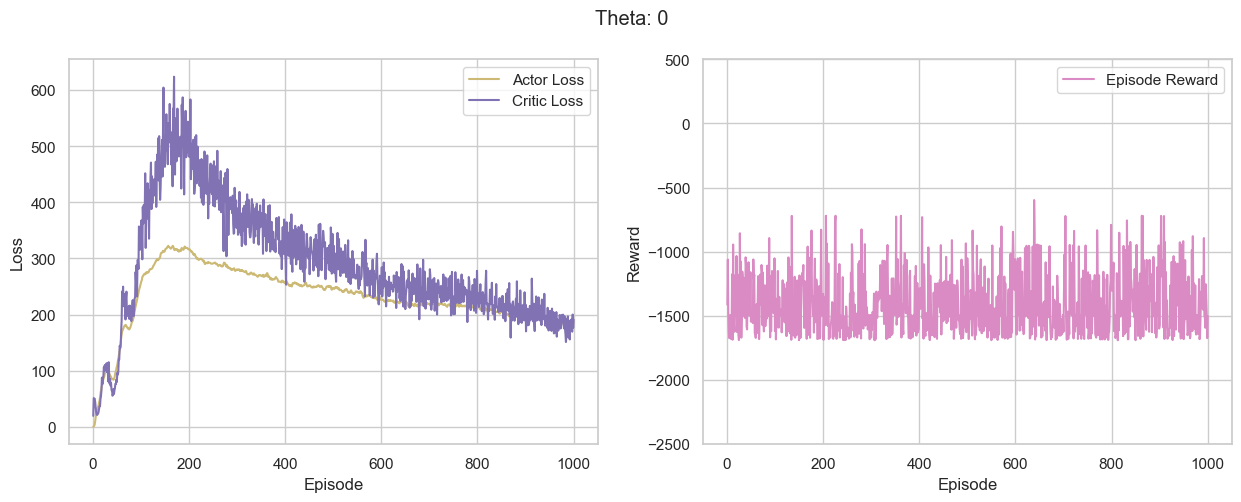

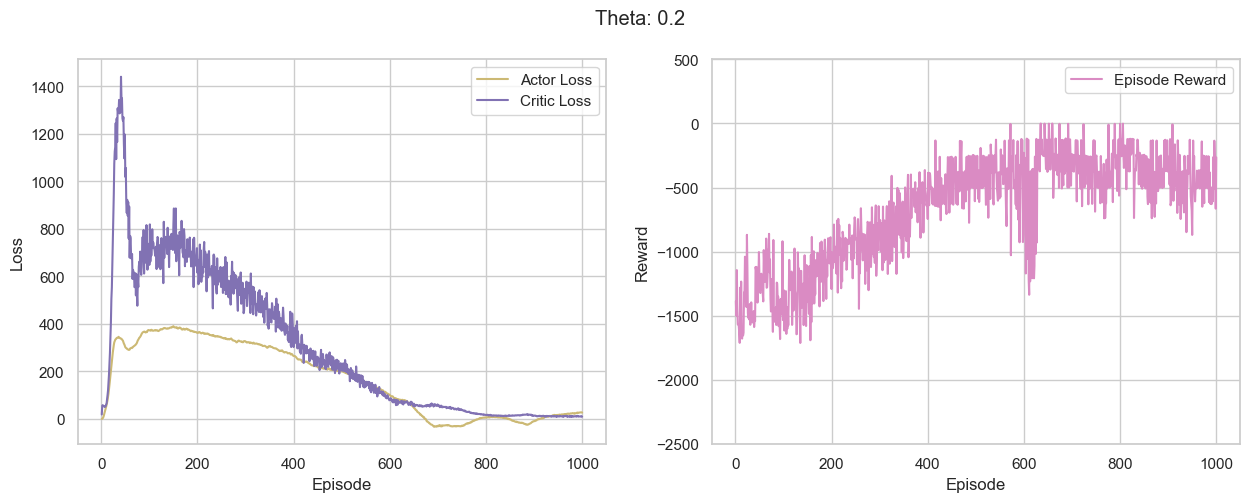

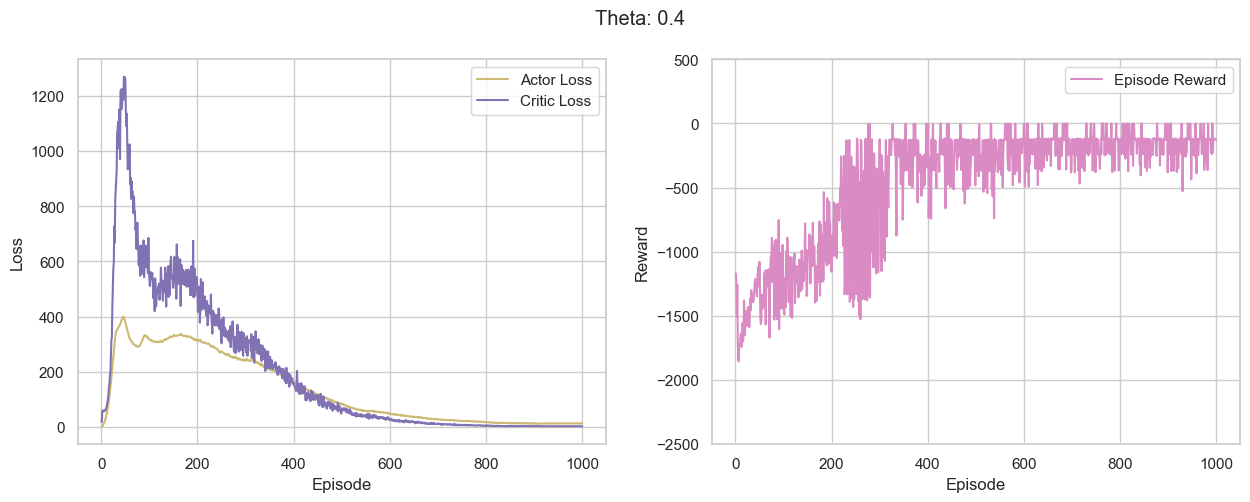

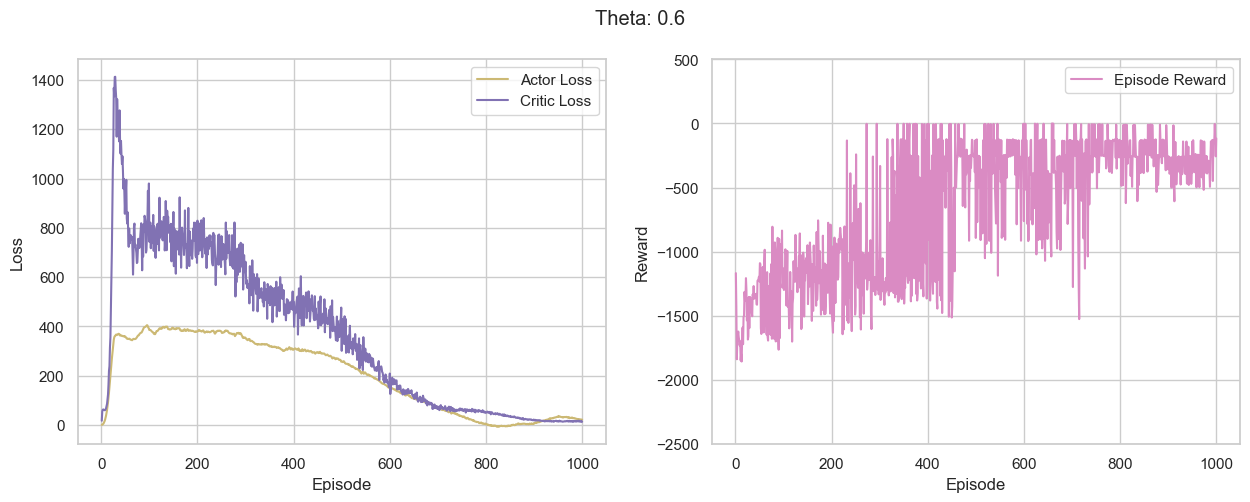

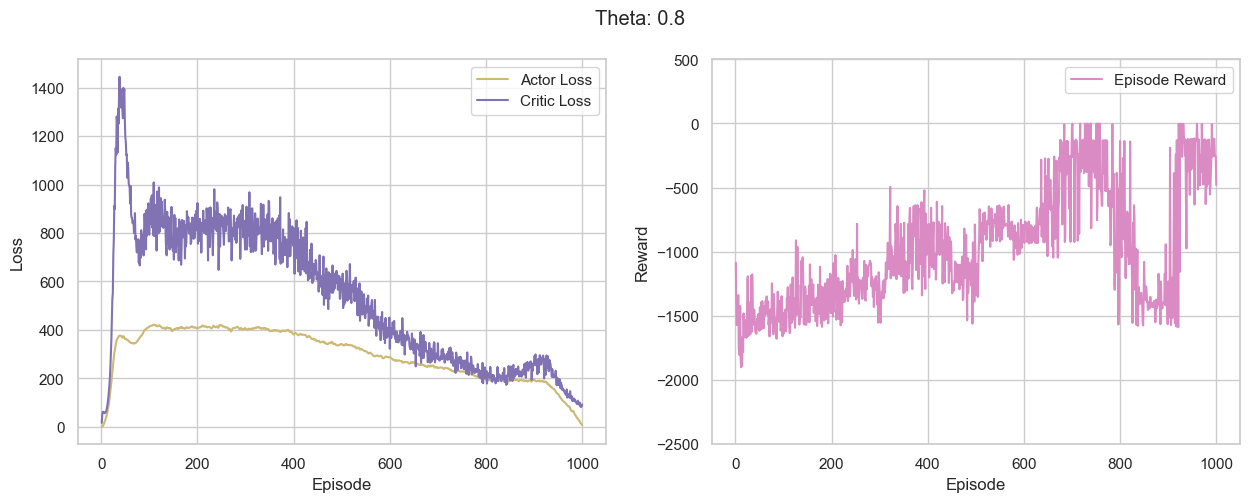

In [ ]:
theta_values = [0, 0.2, 0.4, 0.6, 0.8]

for theta in theta_values:
    df_train = pd.read_csv(
        f'data/q7/ddpg_q7_train_theta_{theta}.csv', index_col='Episode')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Theta: {theta}')
    ax[0].plot(df_train['Actor Loss'], label='Actor Loss', color=colors[8])
    ax[0].plot(df_train['Critic Loss'], label='Critic Loss', color=colors[4])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(df_train['Reward'], label='Episode Reward', color=colors[6])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')
    ax[1].set_ylim([-2500, 500])
    ax[1].legend()
    plt.show()


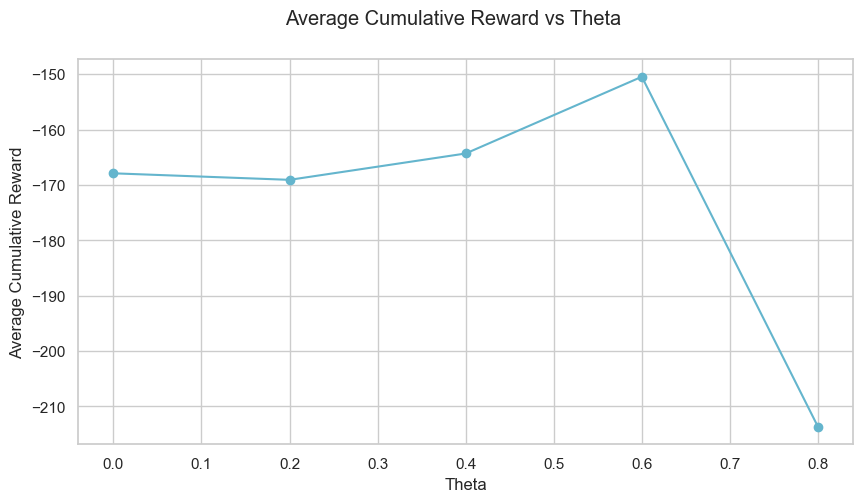

In [ ]:
cumulative_rewards = []

for theta in theta_values:
    df_test = pd.read_csv(
        f'data/q7/ddpg_q7_test_theta_{theta}.csv', index_col='Episode')
    cumulative_rewards.append(np.mean(df_test['Reward'].values))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('Average Cumulative Reward vs Theta')
ax.plot(theta_values, cumulative_rewards, color=colors[9], marker='o')
ax.set_xlabel('Theta')
ax.set_ylabel('Average Cumulative Reward')
plt.show()
